In [1]:
!pip install dython
import itertools
import pandas as pd
import pandas_profiling
import numpy as np
import scipy.stats
import re
import requests
from bs4 import BeautifulSoup
import math
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.backends.backend_agg
import matplotlib.figure
import seaborn as sns
import datetime
import warnings
import dython.nominal as dn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
vehicles_dataset = pd.read_csv(
    'https://raw.githubusercontent.com/AlejandroPenaloza/cars-value-predictor/master/cars-features-dataset.csv')
vehicles_dataset.drop(columns='Unnamed: 0', inplace=True)
print(vehicles_dataset.shape)
vehicles_dataset.head()

(16920, 18)


,Make,Model,Year,Mileage,Transmission,Engine,Exterior Color,Interior Color,MPG,Fuel Type,Drive Type,Location (City),Location (State),Style,Condition (Accidents),Options Level,Bed Length,Price
0,Ford,Focus,2014.0,"35,795",Automatic,2.0L Inline-4 Gas,NaN,Charcoal Black,26 cty / 36 hwy,Gas,FWD,Tacoma,WA,SE Hatchback,2 reported accidents,Standard,NaN,"7,999"
1,Ford,F-150,2015.0,"128,146",Automatic,2.7L V-6 Gas Turbocharged,Unknown,Medium Earth Gray,19 cty / 26 hwy,Gas,RWD,Waxahachie,TX,XL SuperCrew 6.5\' Box RWD,0 reported accidents,NaN,Standard Bed,"15,991"
2,Mercedes-Benz,E-Class,2004.0,"135,000",Automatic,5.0L V-8 Gas,Black,Beige,16 cty / 22 hwy,Gas,AWD,Covina,CA,E 500 4MATIC Wagon,0 reported accidents,Standard,NaN,"5,950"
3,Hyundai,Elantra,2011.0,"135,670",Automatic,1.8L Inline-4 Gas,NaN,Gray,28 cty / 38 hwy,Gas,FWD,Miami,FL,NaN,0 reported accidents,Standard,NaN,"3,999"
4,Toyota,Prius,2012.0,"152,543",Automatic,1.8L Inline-4 Hybrid,White,Biege,51 cty / 48 hwy,Hybrid,FWD,Byhalia,MS,Five,1 reported accidents,Standard,NaN,"6,500"


## Exploratory Data Analysis

In [3]:
#pandas_profiling.ProfileReport(vehicles_dataset)

In [4]:
print(vehicles_dataset.info())
print(vehicles_dataset['Year'].describe())
vehicles_dataset.drop(columns='Year').describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16920 entries, 0 to 16919
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Make                   16024 non-null  object 
 1   Model                  15997 non-null  object 
 2   Year                   16098 non-null  float64
 3   Mileage                16571 non-null  object 
 4   Transmission           16534 non-null  object 
 5   Engine                 13375 non-null  object 
 6   Exterior Color         11080 non-null  object 
 7   Interior Color         15635 non-null  object 
 8   MPG                    16553 non-null  object 
 9   Fuel Type              16584 non-null  object 
 10  Drive Type             16636 non-null  object 
 11  Location (City)        16207 non-null  object 
 12  Location (State)       16172 non-null  object 
 13  Style                  15173 non-null  object 
 14  Condition (Accidents)  16139 non-null  object 
 15  Op

,Make,Model,Mileage,Transmission,Engine,Exterior Color,Interior Color,MPG,Fuel Type,Drive Type,Location (City),Location (State),Style,Condition (Accidents),Options Level,Bed Length,Price
count,16024,15997,16571,16534,13375,11080,15635,16553,16584,16636,16207,16172,15173,16139,14679,1279,16004
unique,121,615,6442,2,122,577,325,274,7,5,1311,52,1327,5,4,3,3217
top,Ford,Sentra,"29,842",Automatic,2.5L Inline-4 Gas,Black,Black,29 cty / 37 hwy,Gas,FWD,Phoenix,TX,SE FWD,0 reported accidents,Standard,Short Bed,"9,995"
freq,2158,563,20,16036,2045,821,4577,638,15625,9719,235,1997,444,13441,9801,603,119


Or...

In [5]:
vehicles_dataset.dtypes

Make                      object
Model                     object
Year                     float64
Mileage                   object
Transmission              object
Engine                    object
Exterior Color            object
Interior Color            object
MPG                       object
Fuel Type                 object
Drive Type                object
Location (City)           object
Location (State)          object
Style                     object
Condition (Accidents)     object
Options Level             object
Bed Length                object
Price                     object
dtype: object

In [6]:
vehicles_dataset.isnull().sum(axis=0)

Make                       896
Model                      923
Year                       822
Mileage                    349
Transmission               386
Engine                    3545
Exterior Color            5840
Interior Color            1285
MPG                        367
Fuel Type                  336
Drive Type                 284
Location (City)            713
Location (State)           748
Style                     1747
Condition (Accidents)      781
Options Level             2241
Bed Length               15641
Price                      916
dtype: int64

In [7]:
# the following is an array with columns sorted by nulls count within them.
columns_by_nulls = vehicles_dataset.isnull().sum().sort_values(ascending=True)
print(columns_by_nulls)
sorted_columns = columns_by_nulls.index.to_numpy()
sorted_columns

Drive Type                 284
Fuel Type                  336
Mileage                    349
MPG                        367
Transmission               386
Location (City)            713
Location (State)           748
Condition (Accidents)      781
Year                       822
Make                       896
Price                      916
Model                      923
Interior Color            1285
Style                     1747
Options Level             2241
Engine                    3545
Exterior Color            5840
Bed Length               15641
dtype: int64


array(['Drive Type', 'Fuel Type', 'Mileage', 'MPG', 'Transmission',
       'Location (City)', 'Location (State)', 'Condition (Accidents)',
       'Year', 'Make', 'Price', 'Model', 'Interior Color', 'Style',
       'Options Level', 'Engine', 'Exterior Color', 'Bed Length'],
      dtype=object)

This high quantity of allegedly null values is due to lack of information when inputting specifications in each car listing from its owner or merchant.
Some of them will be dropped but most of them will be labeled as another data category.

### Make and Model

Starting off with 'Make' and 'Model'

In [8]:
vehicles_dataset.dropna(subset=['Make', 'Model'], inplace=True)
sorted_columns = np.setdiff1d(sorted_columns, np.array(['Make', 'Model']), assume_unique=True)
vehicles_dataset.shape

(15983, 18)

Make and model are too important to have as an specific information for each row, so the ones were Make and Model are missing were dropped.

In [9]:
sorted_columns[0]

'Drive Type'

Now, 'Drive Type' will be analyzed.

In [10]:
vehicles_dataset['Drive Type'].value_counts()

FWD        9347
AWD        2648
4WD        2144
RWD        1813
Unknown       8
Name: Drive Type, dtype: int64

In [11]:
vehicles_dataset['Drive Type'].isnull().sum()

23

This variable has just 23 null values. In addition to that there is one category called 'Unknown', which has only 8 occurrences.
The rows presenting these values are going to be eliminated.

In [12]:
vehicles_dataset["Drive Type"] = vehicles_dataset["Drive Type"].apply(
    lambda dt: (dt, np.NaN)[dt == 'Unknown'])
vehicles_dataset.dropna(subset=["Drive Type"], inplace=True)

In [13]:
# Function to display next feature to analyze and edited
# dataframe shape, after being done with previous one
def display_next_feature(n=1):
  global sorted_columns
  sorted_columns = sorted_columns[n:]
  return print(sorted_columns[0], "\n", vehicles_dataset.shape)
               
  
display_next_feature()

Fuel Type 
 (15952, 18)


The next variable with the least amount of null values is 'Fuel Type'.

In [14]:
print(vehicles_dataset['Fuel Type'].value_counts())
vehicles_dataset['Fuel Type'].isnull().sum()

Gas         14999
Hybrid        482
Diesel        266
Plug-In        99
Electric       64
Hydrogen        3
CNG             2
Name: Fuel Type, dtype: int64


37

'CNG' and 'Hydrogen will be dismissed, they have but 5 presences. 

In [15]:
vehicles_dataset['Fuel Type'] = vehicles_dataset['Fuel Type'].apply(
    lambda ft: (ft, np.NaN)[ft in ['Hydrogen', 'CNG']])
vehicles_dataset.dropna(subset=['Fuel Type'], inplace=True)

In [16]:
display_next_feature()

Mileage 
 (15910, 18)


### Mileage

'Mileage' column comes on.

In [17]:
print(vehicles_dataset['Mileage'].value_counts())
vehicles_dataset['Mileage'].isnull().sum()

29,842     20
148,040    19
152,997    18
51,821     16
94,500     15
           ..
41,801      1
77,284      1
18,343      1
4,171       1
68,144      1
Name: Mileage, Length: 6271, dtype: int64


12

In [18]:
vehicles_dataset.dropna(subset=['Mileage'], inplace=True)

In [19]:
vehicles_dataset['Mileage'] = vehicles_dataset['Mileage'].apply(
    lambda m: m.replace(',', ''))
vehicles_dataset['Mileage'] = vehicles_dataset['Mileage'].astype('int64')

In [20]:
mileage_median = np.median(vehicles_dataset['Mileage'])
print("Median of 'Mileage' data is", mileage_median)
scipy.stats.describe(vehicles_dataset['Mileage'])

Median of 'Mileage' data is 40044.0


DescribeResult(nobs=15898, minmax=(5, 428197), mean=58815.70228959618, variance=2178329907.811407, skewness=1.375201333977781, kurtosis=1.9200097611263107)

Text(0.5, 0, 'Occurrences')

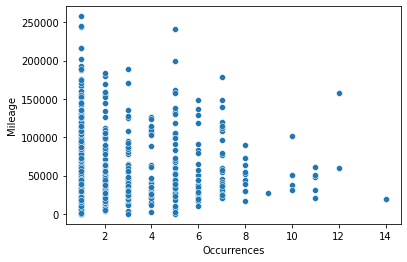

In [21]:
ax = sns.scatterplot(x=vehicles_dataset['Mileage'].value_counts(), 
                     y=vehicles_dataset['Mileage'], data=vehicles_dataset)
ax.set_xlabel('Occurrences')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


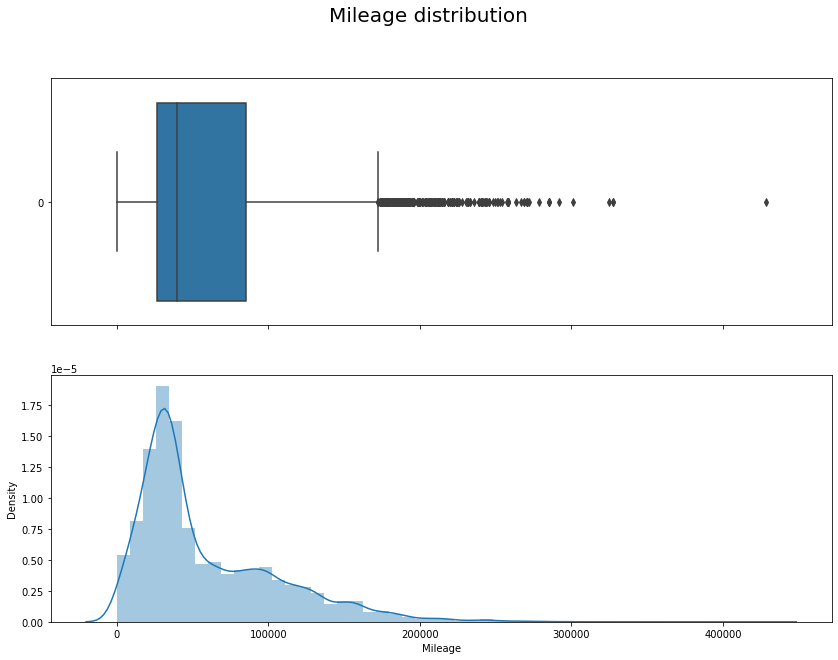

In [22]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(14, 10))
fig.suptitle('Mileage distribution', fontsize=20)
sns.boxplot(orient='h', data=vehicles_dataset['Mileage'], ax=ax_box)
sns.distplot(vehicles_dataset['Mileage'], ax=ax_hist)

It ts clear that many outliers are present here. They are to be dealt with by using 1.5 x Interquartile Range Rule and Z Score measurements.

In [23]:
# absolute value of z-score for every mileage
mileage_std = np.std(vehicles_dataset['Mileage'])
print("Threshold is to be", 3*mileage_std)
z_score = np.abs(scipy.stats.zscore(vehicles_dataset['Mileage']))
z_score

Threshold is to be 140013.34221515374


array([0.49325376, 1.48550767, 1.6323651 , ..., 0.6199274 , 0.25316949,
       1.08355464])

In [24]:
# Quartiles and IQR definition
mileage_iqr = scipy.stats.iqr(vehicles_dataset['Mileage'])

# mileage_iqr = vehicles_dataset['Mileage'].apply(scipy.stats.iqr)
mileage_quartile1 = np.percentile(vehicles_dataset['Mileage'], 25)
mileage_quartile3 = np.percentile(vehicles_dataset['Mileage'], 75)

Z-Score filtering applied by comparing their value with each mileage score, keeping the rows within the +-3 standard deviation range.

In [25]:
# z-score filtered dataframe
z_score_outliers_n = vehicles_dataset.shape[0] - len(vehicles_dataset[z_score <= 3]['Mileage'])
vehicles_dataset = vehicles_dataset[z_score <= 3]
print("New number of rows:", vehicles_dataset.shape[0])
vehicles_dataset['Mileage'].value_counts()

New number of rows: 15705


29842     20
148040    19
152997    18
51821     16
94500     15
          ..
32444      1
120497     1
114348     1
51822      1
38909      1
Name: Mileage, Length: 6173, dtype: int64

In [26]:
print("So,", z_score_outliers_n, 
      "fields have been declared as outliers, thereby left away.")
max_mileage = vehicles_dataset['Mileage'].max()

So, 193 fields have been declared as outliers, thereby left away.


Interquartile Range usage for restricting the array values spread.

In [27]:
# Dataset taking away outliers according to 1.5 times the interquartile range.
IQRx1p5_df = vehicles_dataset[(vehicles_dataset['Mileage'] > mileage_quartile1 - 1.5 * mileage_iqr) & (
      vehicles_dataset['Mileage'] < mileage_quartile3 + 1.5 * mileage_iqr)]
IQRx1p5_rows_n = len(vehicles_dataset['Mileage']) - len(IQRx1p5_df['Mileage'])
print('Current number of rows', len(vehicles_dataset['Mileage']), 
      "- number if all rows eliminated for 1.5x IQR", len(IQRx1p5_df['Mileage']),
      "=", IQRx1p5_rows_n)

Current number of rows 15705 - number if all rows eliminated for 1.5x IQR 15454 = 251


Due to limiting the values range whisker to 1.5 IQR takes away over 200 more rows (nearly 500 from original dataset, which is a lot to this standard), some of those values will be kept, by representing the median value. 

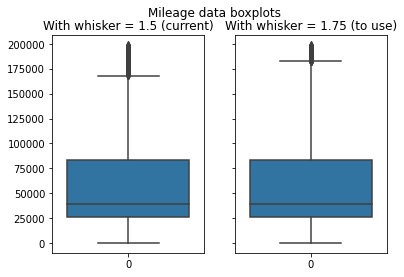

In [28]:
fig, (box1, box2) = plt.subplots(ncols=2, sharey=True)
fig.suptitle('Mileage data boxplots')
sns.boxplot(orient='v', data=vehicles_dataset['Mileage'], ax=box1, whis=1.5)
box1.set_title('With whisker = 1.5 (current)')
sns.boxplot(orient='v', data=vehicles_dataset['Mileage'], ax=box2, whis=1.75)
box2.set_title('With whisker = 1.75 (to use)')
plt.show()

In [29]:
# Dataset taking away outliers according to 1.75 times the interquartile range
IQRx1p75_df = vehicles_dataset[(vehicles_dataset['Mileage'] > mileage_quartile1 - 1.75 * mileage_iqr) & (
      vehicles_dataset['Mileage'] < mileage_quartile3 + 1.75 * mileage_iqr)]
IQRx1p75_rows_n = len(vehicles_dataset['Mileage']) - len(IQRx1p75_df['Mileage'])
print("Current number of rows ", len(vehicles_dataset['Mileage']), 
      " - number if all rows eliminated for 1.75x IQR ", len(IQRx1p75_df['Mileage']),
      " = ", IQRx1p75_rows_n, ".", sep="")
print("And the rest (will be changed instead of eliminated): ", IQRx1p5_rows_n - IQRx1p75_rows_n, ".", sep="")

Current number of rows 15705 - number if all rows eliminated for 1.75x IQR 15635 = 70.
And the rest (will be changed instead of eliminated): 181.


Now, these 70 rows will be dropped and the rest of outliers (181) are to storage the mileage median value.

In [30]:
vehicles_dataset = IQRx1p75_df

# Given that there are no low outliers, we can determine what outliers value to replace by comparing with the new max mileage value
vehicles_dataset['Mileage'].where(vehicles_dataset['Mileage'] <= IQRx1p5_df['Mileage'].max(), other=mileage_median, inplace=True)

In [31]:
display_next_feature()

MPG 
 (15635, 18)


### MPG

Following into the variables list with the least null values, 'MPG' comes up.

In [32]:
print(vehicles_dataset['MPG'].value_counts())
vehicles_dataset['MPG'].isnull().sum()

17 cty / 25 hwy      597
29 cty / 37 hwy      590
N/A cty / N/A hwy    508
28 cty / 39 hwy      381
26 cty / 33 hwy      364
                    ... 
11 cty / N/A hwy       1
18 cty / 30 hwy        1
129 cty / 102 hwy      1
44 cty / 41 hwy        1
25 cty / 26 hwy        1
Name: MPG, Length: 269, dtype: int64


18

This column has only 18 null values, however, they are also represented as True in 'N/A cty / N/A hwy', as seen down below.
Since there are around 500 of these values, they will be categorized as well.

In [33]:
sorted(list(vehicles_dataset.dropna(subset=['MPG'])['MPG'].unique()))

['10 cty / 16 hwy',
 '10 cty / 17 hwy',
 '101 cty / 93 hwy',
 '102 cty / 105 hwy',
 '104 cty / 91 hwy',
 '106 cty / 92 hwy',
 '11 cty / 15 hwy',
 '11 cty / 16 hwy',
 '11 cty / 17 hwy',
 '11 cty / 18 hwy',
 '11 cty / N/A hwy',
 '12 cty / 14 hwy',
 '12 cty / 16 hwy',
 '12 cty / 17 hwy',
 '12 cty / 18 hwy',
 '12 cty / 19 hwy',
 '120 cty / 112 hwy',
 '121 cty / 103 hwy',
 '122 cty / 108 hwy',
 '122 cty / 93 hwy',
 '124 cty / 94 hwy',
 '126 cty / 101 hwy',
 '126 cty / 105 hwy',
 '126 cty / 99 hwy',
 '129 cty / 102 hwy',
 '13 cty / 16 hwy',
 '13 cty / 17 hwy',
 '13 cty / 18 hwy',
 '13 cty / 19 hwy',
 '13 cty / 20 hwy',
 '13 cty / 21 hwy',
 '13 cty / 22 hwy',
 '137 cty / 111 hwy',
 '14 cty / 17 hwy',
 '14 cty / 18 hwy',
 '14 cty / 19 hwy',
 '14 cty / 20 hwy',
 '14 cty / 21 hwy',
 '14 cty / 22 hwy',
 '14 cty / 23 hwy',
 '14 cty / 24 hwy',
 '15 cty / 17 hwy',
 '15 cty / 18 hwy',
 '15 cty / 19 hwy',
 '15 cty / 20 hwy',
 '15 cty / 21 hwy',
 '15 cty / 22 hwy',
 '15 cty / 23 hwy',
 '15 cty / 24 hwy

In [34]:
def MPG_categorize(MPG):
    if MPG in ['N/A cty / N/A hwy', np.NaN]:
        return 'Another'
    else:
        cty = int(re.findall('[0-9]+ c', str(MPG))[0][:-2])
        hwy = re.findall('/ [0-9]+', str(MPG))
        if hwy == []:
            return 'Another'
        elif cty >= 60:
            return 'up from 60 cty / up from 50 hwy'
        else:
            hwy = int(hwy[0][2:])
            return str(cty)[0] + "0-" + str(cty)[0] + "9 cty / " + str(hwy)[0] + "0-" + str(hwy)[0] + "9 hwy"

vehicles_dataset['MPG'] = vehicles_dataset['MPG'].apply(MPG_categorize)
vehicles_dataset['MPG'].value_counts()

20-29 cty / 30-39 hwy              6961
10-19 cty / 20-29 hwy              4112
20-29 cty / 20-29 hwy              1861
30-39 cty / 40-49 hwy               635
Another                             527
30-39 cty / 30-39 hwy               476
10-19 cty / 10-19 hwy               383
40-49 cty / 40-49 hwy               301
10-19 cty / 30-39 hwy               104
up from 60 cty / up from 50 hwy      94
20-29 cty / 40-49 hwy                81
40-49 cty / 30-39 hwy                45
50-59 cty / 40-49 hwy                40
50-59 cty / 50-59 hwy                 9
30-39 cty / 20-29 hwy                 6
Name: MPG, dtype: int64

30, 40 and 50 cty categories are being gathered so outliers disappear.

In [35]:
def MPG_categorize2(MPG):
    if MPG in ['30-39 cty / 20-29 hwy', '30-39 cty / 30-39 hwy']:
        return '30-39 cty / 20-39 hwy'
    elif MPG in ['50-59 cty / 40-49 hwy', '50-59 cty / 50-59 hwy']:
        return '50-59 cty / 40-59 hwy'
    elif MPG in ['40-49 cty / 30-39 hwy', '40-49 cty / 40-49 hwy']:
        return '40-49 cty / 30-49 hwy'
    else:
        return MPG
    

vehicles_dataset['MPG'] = vehicles_dataset['MPG'].apply(MPG_categorize2)
vehicles_dataset['MPG'].value_counts()

20-29 cty / 30-39 hwy              6961
10-19 cty / 20-29 hwy              4112
20-29 cty / 20-29 hwy              1861
30-39 cty / 40-49 hwy               635
Another                             527
30-39 cty / 20-39 hwy               482
10-19 cty / 10-19 hwy               383
40-49 cty / 30-49 hwy               346
10-19 cty / 30-39 hwy               104
up from 60 cty / up from 50 hwy      94
20-29 cty / 40-49 hwy                81
50-59 cty / 40-59 hwy                49
Name: MPG, dtype: int64

In [36]:
display_next_feature()

Transmission 
 (15635, 18)


### Transmission

'Transmission' feature presents only two true values, as logically thought. We will just get rid of null values then.

In [37]:
print(vehicles_dataset['Transmission'].isnull().sum())
vehicles_dataset['Transmission'].value_counts()

13


Automatic    15153
Manual         469
Name: Transmission, dtype: int64

In [38]:
vehicles_dataset.dropna(subset=['Transmission'], inplace=True)

In [39]:
display_next_feature()

Location (City) 
 (15622, 18)


The places where the vehicles are located are defined by city and state as two variables -'Location (City)' and Location (State)'-.

These variables describing vehicle location will be analyzed later on.

In [40]:
display_next_feature(2)

Condition (Accidents) 
 (15622, 18)


### Condition (Accidents)

'Condition (Accidents)' is the next characteristic to check out.

In [41]:
print(vehicles_dataset['Condition (Accidents)'].value_counts())
vehicles_dataset['Condition (Accidents)'].isnull().sum()

0 reported accidents    12916
1 reported accidents     2186
2 reported accidents      324
3 reported accidents       37
4 reported accidents       11
Name: Condition (Accidents), dtype: int64


148

There are 148 null values, and they will be replaced by another category ('Unknown), along the value '4 reported accidents', as it has very few instances.

In [42]:
vehicles_dataset['Condition (Accidents)'] = vehicles_dataset['Condition (Accidents)'].apply(
    lambda cond: (cond, 'Unknown')[cond in ['4 reported accidents', np.NaN]])
vehicles_dataset['Condition (Accidents)'].value_counts()

0 reported accidents    12916
1 reported accidents     2186
2 reported accidents      324
Unknown                   159
3 reported accidents       37
Name: Condition (Accidents), dtype: int64

In [43]:
display_next_feature()

Year 
 (15622, 18)


### Year

Intuitively, vehicles model years is represented in 'Year' column.

In [44]:
print(vehicles_dataset['Year'].isnull().sum())
vehicles_dataset['Year'].value_counts()

6


2019.0    4211
2017.0    3918
2018.0    1116
2016.0     922
2015.0     802
2014.0     720
2020.0     662
2013.0     657
2012.0     488
2010.0     377
2011.0     373
2007.0     275
2009.0     253
2008.0     234
2006.0     167
2005.0     127
2004.0      92
2003.0      83
2002.0      57
2001.0      38
1999.0      16
2000.0      14
1998.0       9
1997.0       5
Name: Year, dtype: int64

In [45]:
vehicles_dataset['Year'] = vehicles_dataset['Year'].where(
    vehicles_dataset['Year'] > 2000, other='Other')
vehicles_dataset['Year'].fillna('Other', inplace=True)
vehicles_dataset['Year'] = vehicles_dataset['Year'].astype('object')
vehicles_dataset['Year'].value_counts()

2019.0    4211
2017.0    3918
2018.0    1116
2016.0     922
2015.0     802
2014.0     720
2020.0     662
2013.0     657
2012.0     488
2010.0     377
2011.0     373
2007.0     275
2009.0     253
2008.0     234
2006.0     167
2005.0     127
2004.0      92
2003.0      83
2002.0      57
Other       50
2001.0      38
Name: Year, dtype: int64

In [46]:
display_next_feature()

Price 
 (15622, 18)


### Price

Now, 'Price' feature, which is the variable to predict in the upcoming model.

In [47]:
print(vehicles_dataset['Price'].isnull().sum())
vehicles_dataset['Price'].value_counts()

263


14,995    113
9,995     108
10,995    104
13,995     96
7,995      92
         ... 
25,974      1
14,397      1
24,891      1
18,558      1
29,338      1
Name: Price, Length: 3146, dtype: int64

Since this variable is needed to be as reliable and accurate as possible, the null values will not be rearranged so this data does not be that altered, they will be instead dropped.

In [48]:
vehicles_dataset.dropna(subset=['Price'], inplace=True)

In [49]:
vehicles_dataset['Price'] = vehicles_dataset['Price'].apply(lambda p: float(str(p).replace(',', '')))
scipy.stats.describe(vehicles_dataset['Price'])

DescribeResult(nobs=15359, minmax=(1600.0, 369900.0), mean=17423.347548668535, variance=145533679.35100827, skewness=8.811278386572319, kurtosis=199.32899503544752)

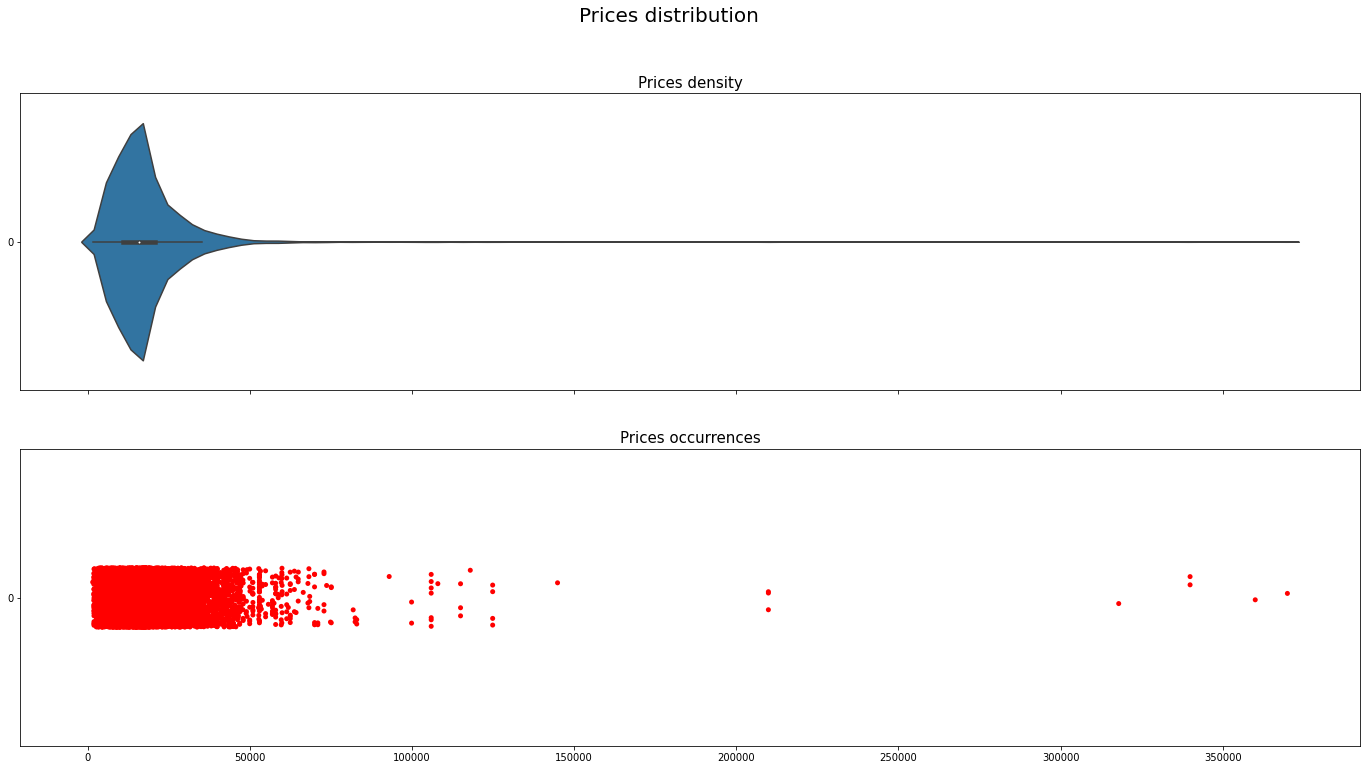

In [50]:
fig, (ax_violin, ax_strip) = plt.subplots(2, sharex=True, figsize=(24, 12))
fig.suptitle('Prices distribution', fontsize=20)
ax_violin.set_title('Prices density', fontdict={'fontsize': 15})
ax_strip.set_title('Prices occurrences', fontdict={'fontsize': 15})
sns.violinplot(orient='h', data=vehicles_dataset['Price'], ax=ax_violin)
sns.stripplot(orient='h', data=vehicles_dataset['Price'], ax=ax_strip, color='red')

Outliers are noticeable, they have to be worked out.
As before, we are to apply Z-Score.

In [51]:
# absolute value of z-score for every price in column
price_std = np.std(vehicles_dataset['Price'])
print("Prices threshold to use is", 3*price_std)
z_score_prices = np.abs(scipy.stats.zscore(vehicles_dataset['Price']))
z_score_prices

Prices threshold to use is 36190.02397024339


array([0.78123857, 0.11873556, 0.95109201, ..., 0.61978288, 0.00220938,
       0.17601654])

In [52]:
# Quartiles and IQR definition
price_iqr = scipy.stats.iqr(vehicles_dataset['Price'])
price_quartile1 = np.percentile(vehicles_dataset['Price'], 25)
price_quartile3 = np.percentile(vehicles_dataset['Price'], 75)

# z-score filtered dataframe
original_rows_number = vehicles_dataset.shape[0]
vehicles_dataset = vehicles_dataset[z_score_prices <= 3]
price_outliers_number = original_rows_number - vehicles_dataset.shape[0]
print("Number of rows taken away:", price_outliers_number)
print("New number of rows:", vehicles_dataset.shape[0])

Number of rows taken away: 128
New number of rows: 15231


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


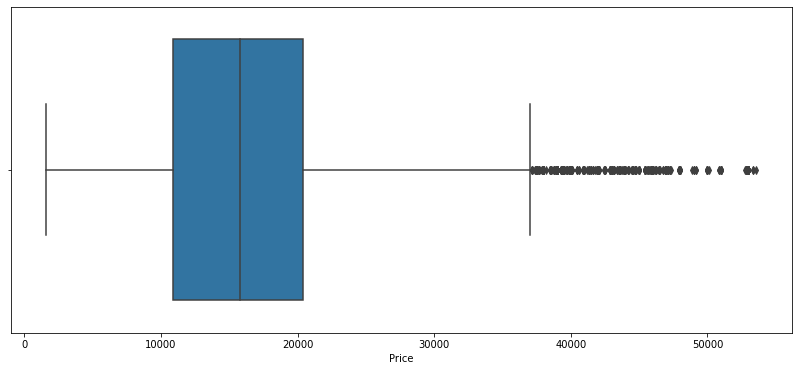

In [53]:
fig, ax = plt.subplots(figsize=(14,6))
sns.boxplot(vehicles_dataset['Price'], whis=1.75, ax=ax)

'Prices' still presents outliers.
The values spread will be restricted to 1.75 Interquartile Range measures, as used with 'Mileage'.

In [54]:
# filtered dataframe taking away values off 1.75 times the interquartile range
filtered_175_df = vehicles_dataset[(vehicles_dataset['Price'] > price_quartile1 - 1.75 * price_iqr) & (
      vehicles_dataset['Price'] < price_quartile3 + 1.75 * price_iqr)]
outliers_number = len(vehicles_dataset['Price']) - len(filtered_175_df['Price'])
print(
    "Number of rows off of threshold:", vehicles_dataset.shape[0], "-", 
    filtered_175_df.shape[0], "=", outliers_number)

Number of rows off of threshold: 15231 - 14718 = 513


Despite of modified data was not wanted, it is required to apply some procedures in some of these fields, so we do not lose this much information.
The whisker mark will be increased to 2.00 to check on the values.

In [55]:
# filtered dataframe taking away values off 2 times the interquartile range
filtered_200_df = vehicles_dataset[(vehicles_dataset['Price'] > price_quartile1 - 2 * price_iqr) & (
      vehicles_dataset['Price'] < price_quartile3 + 2 * price_iqr)]
print("Number of rows to be eliminated:", vehicles_dataset.shape[0] - filtered_200_df.shape[0])
print("Number of rows to be reassigned:", filtered_200_df.shape[0] - filtered_175_df.shape[0])

Number of rows to be eliminated: 324
Number of rows to be reassigned: 189


(14907, 18)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


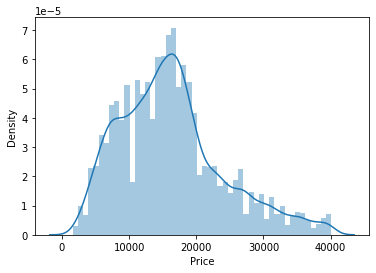

In [56]:
vehicles_dataset = filtered_200_df
price_mean = np.mean(vehicles_dataset['Price'])
vehicles_dataset['Price'].where(vehicles_dataset['Price'] > price_quartile3 + 1.75 * price_iqr, other=price_mean)
print(vehicles_dataset.shape)
sns.distplot(vehicles_dataset['Price'])

In [57]:
display_next_feature()

Interior Color 
 (14907, 18)


### Interior Color

'Interior Color' variable is next to evaluate.

In [58]:
vehicles_dataset['Interior Color'].value_counts()

Black              4084
Charcoal           1679
Unknown            1298
Gray               1224
Jet Black           749
                   ... 
Coral Red/Black       1
Black / Carbon        1
Jade/Graystone        1
Chestnut              1
Choccachino           1
Name: Interior Color, Length: 295, dtype: int64

In [59]:
print("'Interior Color' has", vehicles_dataset['Interior Color'].nunique(), "unique values")
print("and 'Exterior Color' has ", vehicles_dataset['Exterior Color'].nunique(), ".", sep="")

'Interior Color' has 295 unique values
and 'Exterior Color' has 531.


Both 'Interior Color' and 'Exterior Color' has a lot of unique values, but they can be regrouped given that these values represent almost the same color for each case, by category.

In [60]:
print("'Interior Color' has", vehicles_dataset['Interior Color'].isnull().sum(), "null values")
print("and 'Exterior Color' has ", vehicles_dataset['Exterior Color'].isnull().sum(), "!", sep="")

'Interior Color' has 715 null values
and 'Exterior Color' has 4874!


In [61]:
sorted_columns = np.setdiff1d(sorted_columns, np.array(['Exterior Color']), assume_unique=True)

We will create a function which re-categorizes color values (including null values, given that there are a lot of them, 763 and 5126 respectively).

The following function will check whether the passed color names belong to the same category.

In [62]:
def color_in(color, *argc):
    checks = []
    for arg in argc:
        if arg in str(color).lower():
            checks.append(True)
        else:
            checks.append(False)
    if any(checks):
        return True
    else:
        return False

Now, this function will tell if the conditions are met so that it categorizes the original values to this set-up. 

In [63]:
def colors_categorize(ext_color):
    if color_in(ext_color, "black") or "Obsidian" == ext_color:
        return "Black"
    elif color_in(
        ext_color, "white", "glacier") or ext_color in ["Fresh Powder", "Blizzard Pearl", "Starfire Pearl"]:
        return "White"
    elif color_in(ext_color, "green"):
        return "Green"
    elif color_in(ext_color, "blue", "aqua"):
        return "Blue"
    elif color_in(
        ext_color, "silver", "gray", "magnetic", "pearlcoat", "tungsten", 
        "graphite", "gun", "platinum", "titanium", "billet"):
        return "Silver or Grey"
    elif color_in(ext_color, "red", "cherry", "ruby", "sun", "rosso", "scarlet"):
        return "Red"
    elif color_in(ext_color, "gold"):
        return "Gold"
    elif color_in(ext_color, "brown", "beige"):
        return "Beige or Brown"
    elif color_in(ext_color, "yellow"):
        return "Yellow"
    else:
        return "Other"

In [64]:
vehicles_dataset['Interior Color'] = vehicles_dataset['Interior Color'].apply(colors_categorize)
vehicles_dataset['Interior Color'].value_counts()

Other             6243
Black             6179
Silver or Grey    1885
Beige or Brown     564
White               13
Red                 10
Blue                 7
Green                5
Gold                 1
Name: Interior Color, dtype: int64

In [65]:
# keeping on filtering the values
vehicles_dataset['Interior Color'] = vehicles_dataset['Interior Color'].apply(
    lambda i_color: (i_color, 'Other')[i_color in ['Gold', 'Green', 'Blue']])
vehicles_dataset['Interior Color'].value_counts()

Other             6256
Black             6179
Silver or Grey    1885
Beige or Brown     564
White               13
Red                 10
Name: Interior Color, dtype: int64

In [ ]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
fig, (vs_intc) = plt.subplots(2, figsize=(15,10))
sns.violinplot(x='Interior Color', y='Price', data=vehicles_dataset, split=True, ax=vs_intc)
sns.swarmplot(x='Interior Color', y='Price', data=vehicles_dataset, split=True, ax=vs_intc)

### Exterior Color

In [67]:
vehicles_dataset['Exterior Color'].value_counts()

Black               700
Oxford White        403
Summit White        365
Gray                336
White               321
                   ... 
Rhino Clearcoat       1
0040                  1
Botanical Green       1
Torred Clearcoat      1
Ice Storm             1
Name: Exterior Color, Length: 531, dtype: int64

In [68]:
vehicles_dataset['Exterior Color'] = vehicles_dataset['Exterior Color'].apply(colors_categorize)
vehicles_dataset['Exterior Color'].value_counts()

Other             5369
White             3112
Black             2478
Silver or Grey    2430
Blue               792
Red                600
Beige or Brown      54
Gold                45
Green               22
Yellow               5
Name: Exterior Color, dtype: int64

In [69]:
vehicles_dataset['Exterior Color'].where(
    vehicles_dataset['Exterior Color'] != 'Yellow', other='Other', inplace=True)
vehicles_dataset['Exterior Color'].value_counts()

Other             5374
White             3112
Black             2478
Silver or Grey    2430
Blue               792
Red                600
Beige or Brown      54
Gold                45
Green               22
Name: Exterior Color, dtype: int64

In [ ]:
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
# fig, (sw_intc, sw_extc) = plt.subplots(1, 2, sharey=True, figsize=(10, 8))
fig, (sw_intc, sw_extc) = plt.subplots(2, figsize=(10, 8))
fig.suptitle('Colors occurrences regarding vehicle Price')
sns.swarmplot(x='Interior Color', y='Price', data=vehicles_dataset, ax=sw_intc)
sns.swarmplot(x='Exterior Color', y='Price', data=vehicles_dataset, ax=sw_extc)

In [71]:
display_next_feature()

Style 
 (14907, 18)


### Style

'Style' feature is up.

In [72]:
print(vehicles_dataset['Style'].isnull().sum())
vehicles_dataset['Style'].value_counts()

1030


SE FWD                       422
SXT                          376
LE CVT                       369
SV CVT                       350
LX Sedan CVT                 322
                            ... 
EX Sedan I4 CVT                1
ESV AWD                        1
Roadster 2.5i                  1
2014 Hybrid XLE                1
Premium Plus 3.6L quattro      1
Name: Style, Length: 1203, dtype: int64

In [73]:
list(vehicles_dataset['Style'].unique())

['SE Hatchback',
 "XL SuperCrew 6.5\\' Box RWD",
 'E 500 4MATIC Wagon',
 nan,
 'Five',
 'E 350 4MATIC Luxury Sedan',
 'EX-L 4WD',
 'S CVT',
 'Hybrid Limited AWD',
 'LE I4 Automatic',
 'SE AWD',
 '3500 LT LWB',
 'Hybrid Titanium FWD',
 'LT with 1LT',
 'Laredo 4WD',
 'SXT',
 'S 4WD',
 'SL AWD CVT',
 'SE FWD',
 'LX Sedan Automatic',
 'LS 460 RWD',
 'SportWagen TDI DSG',
 'SV CVT',
 'E 300 Sedan RWD',
 '2.5i Premium CVT (PZEV)',
 'EX-L AWD',
 'LTZ 4WD',
 'Hatchback',
 '328i Sedan',
 'XLT FWD',
 'SEL FWD',
 'SRT8',
 'LX FWD',
 'Sport Sedan CVT',
 'SEL 2.4L',
 'Denali FWD',
 'LT 4WD',
 'S Hardtop 2-Door',
 'RX 350 FWD',
 '2.5 SR',
 'SE',
 '+ Automatic',
 'Z71 4WD',
 'SR FWD',
 'SV FWD',
 '3.0si AWD',
 'SE 2.4L AWD',
 'LX',
 'SE Automatic',
 'NX Turbo FWD',
 'GT FWD',
 'SE Plus AWD',
 'SXT RWD',
 'EcoBoost Fastback',
 'Hybrid SE FWD',
 'S\\xa0Automatic',
 'ES 350',
 'SE Sedan',
 'SE Hatch',
 'Limited FWD',
 'IS 200t RWD',
 'S FWD',
 'LE CVT',
 '3.2L',
 'GXE Auto',
 'xDrive28i AWD',
 'SL 500 R

In [74]:
styles_url = requests.get('https://en.wikipedia.org/wiki/Car_body_style')
styles_soup = BeautifulSoup(styles_url.content, 'html.parser')
styles_soup

<!DOCTYPE html>

<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>Car body style - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"X-ukiwpAAEUAADpC2AEAAACT","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Car_body_style","wgTitle":"Car body style","wgCurRevisionId":993432026,"wgRevisionId":993432026,"wgArticleId":679801,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from April 2019","Articles needing additional references from April 2019","All articles needing additional references","Commons category link is on Wikidata","Car b

In [75]:
styles_tags = styles_soup.find_all('dt')
styles_tags

[<dt><a href="/wiki/Buggy_(automobile)" title="Buggy (automobile)">Buggy</a></dt>,
 <dt><a href="/wiki/Convertible" title="Convertible">Convertible</a> / cabriolet</dt>,
 <dt><a href="/wiki/Coup%C3%A9" title="Coupé">Coupé</a></dt>,
 <dt><a href="/wiki/Flower_car" title="Flower car">Flower car</a></dt>,
 <dt><a href="/wiki/Hatchback" title="Hatchback">Hatchback</a> / Liftback</dt>,
 <dt><a href="/wiki/Hearse" title="Hearse">Hearse</a> / funeral coach</dt>,
 <dt>Kombi</dt>,
 <dt><a href="/wiki/Limousine" title="Limousine">Limousine</a></dt>,
 <dt><a href="/wiki/Microvan" title="Microvan">Microvan</a></dt>,
 <dt><a href="/wiki/Minivan" title="Minivan">Minivan</a> / multi-purpose vehicle (MPV) / people carrier / people mover</dt>,
 <dt><a href="/wiki/Panel_van" title="Panel van">Panel van</a> / car-derived van / sedan delivery</dt>,
 <dt><a href="/wiki/Panel_truck" title="Panel truck">Panel truck</a></dt>,
 <dt><a href="/wiki/Pickup_truck" title="Pickup truck">Pickup truck</a> / pickup</dt

In [76]:
styles = np.array([])


for style_tags in styles_tags:
    try:
        style = re.findall('e=".+"', str(style_tags))[0][3:-1]
        styles = np.append(styles, style)
    except IndexError:
        style = re.findall('>.+<', str(style_tags))[0][1:-1]
        styles = np.append(styles, style)


styles

array(['Buggy (automobile)', 'Convertible', 'Coupé', 'Flower car',
       'Hatchback', 'Hearse', 'Kombi', 'Limousine', 'Microvan', 'Minivan',
       'Panel van', 'Panel truck', 'Pickup truck',
       'Roadster (automobile)', 'Sedan (car)', 'Shooting-brake',
       'Station wagon', 'Targa top',
       'Ute (vehicle)">Ute</a> / <a class="mw-redirect" href="/wiki/Coupe_utility" title="Coupe utility',
       'Baquet (car body style)', 'Barchetta', 'Berlinetta',
       'Cabrio coach', 'Coupé de ville', 'Hardtop', 'Landaulet (car)',
       'Personal luxury car', 'Phaeton body'], dtype='<U95')

In [77]:
styles_to_check = [
    "Buggy", "Sedan", "Roadster", "Landaulet", "Ute", "Baquet", "Phaeton"]


def style_cleaner(s):
    if "luxury" in s:
        return "Luxury"
    elif any(item in s for item in styles_to_check):
        return re.findall(".+ \(|.+ b", s)[0][:-2]
    else:
        return s

In [78]:
style_vect_cleaner = np.vectorize(style_cleaner)
styles_vector = style_vect_cleaner(styles)
styles_vector

array(['Buggy', 'Convertible', 'Coupé', 'Flower car', 'Hatchback',
       'Hearse', 'Kombi', 'Limousine', 'Microvan', 'Minivan', 'Panel van',
       'Panel truck', 'Pickup truck', 'Roadster', 'Sedan',
       'Shooting-brake', 'Station wagon', 'Targa top', 'Ute', 'Baquet',
       'Barchetta', 'Berlinetta', 'Cabrio coach', 'Coupé de ville',
       'Hardtop', 'Landaulet', 'Luxury', 'Phaeton'], dtype='<U14')

In [79]:
def style_categorize(style):
    for style_comp in styles_vector:
        if str(style_comp).lower() in str(style).lower():
            return style_comp
        else:
            return "Another"


vehicles_dataset['Style'].apply(style_categorize).value_counts()

Another    14907
Name: Style, dtype: int64

In [ ]:
def style_categorize(style):
    if 'sedan' in style.lower():
        return 'Sedan'
    elif 'convertible' in style.lower():
        return 'Convertible'
    elif 


'Bed Length' is next to go through.

In [81]:
print("'Bed Length' column has", vehicles_dataset["Bed Length"].isnull().sum(), "null values.")
print("The other ones (", vehicles_dataset["Bed Length"].notnull().sum(), ") are:", sep="")
vehicles_dataset['Bed Length'].value_counts()

'Bed Length' column has 13891 null values.
The other ones (1016) are:


Short Bed       492
Standard Bed    423
Long Bed        101
Name: Bed Length, dtype: int64

As seen above the bed length is null for almost all cases, so it will be discarded.

In [82]:
vehicles_dataset.drop(columns='Bed Length', inplace=True)
vehicles_dataset.columns

Index(['Make', 'Model', 'Year', 'Mileage', 'Transmission', 'Engine',
       'Exterior Color', 'Interior Color', 'MPG', 'Fuel Type', 'Drive Type',
       'Location (City)', 'Location (State)', 'Style', 'Condition (Accidents)',
       'Options Level', 'Price'],
      dtype='object')

Now, 

Like there are just a few cases where the vehicles are yellow or green, we will get rid of these values.

In [83]:
colors_to_drop = list(vehicles_dataset['Exterior Color'].value_counts().index[-4:])
colors_to_drop

['Red', 'Beige or Brown', 'Gold', 'Green']

In [84]:
indexes = []


for color in colors_to_drop:
    indexes += list(vehicles_dataset[vehicles_dataset["Exterior Color"] == color].index)
    
    
vehicles_dataset.drop(indexes, inplace=True)
vehicles_dataset.shape

(14186, 17)

Text(0.5, 1.0, 'Exterior colors by occurrences')

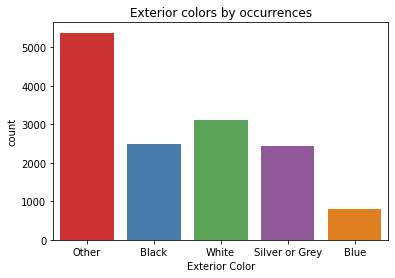

In [85]:
ax = sns.countplot(x="Exterior Color", data=vehicles_dataset, palette="Set1")
ax.set_title("Exterior colors by occurrences")

Now, 'Engine' will be analyzed.

In [86]:
vehicles_dataset['Engine'].isnull().sum()

2668

In [87]:
vehicles_dataset['Engine'].value_counts()

2.5L Inline-4 Gas            1892
1.8L Inline-4 Gas            1292
3.6L V-6 Gas                 1259
2.4L Inline-4 Gas            1257
3.5L V-6 Gas                 1132
                             ... 
3.8L Flat-6 Gas                 1
3.5L Inline-5 Gas               1
1.7L Inline-4 Gas               1
5.0L V-10 Gas                   1
4.6L V-8 Gas Turbocharged       1
Name: Engine, Length: 105, dtype: int64

We are going to check on all the variants for each 'Inline', 'Flat' and 'Vs' engines, so we can filter them into more crowded categories

In [88]:
sorted(vehicles_dataset['Engine'].value_counts().index.to_list())

['0.6L Inline-2 Plug-In',
 '1.0L Inline-3 Gas',
 '1.2L Inline-3 Gas',
 '1.3L Inline-4 Hybrid',
 '1.4L Inline-4 Gas',
 '1.4L Inline-4 Plug-In',
 '1.5L Inline-4 Gas',
 '1.5L Inline-4 Hybrid',
 '1.5L Inline-4 Plug-In',
 '1.6L Inline-4 Gas',
 '1.6L Inline-4 Hybrid',
 '1.7L Inline-4 Gas',
 '1.8L Inline-4 Gas',
 '1.8L Inline-4 Hybrid',
 '1.8L Inline-4 Plug-In',
 '2.0L Flat-4 Gas',
 '2.0L Inline-4 Gas',
 '2.0L Inline-4 Hybrid',
 '2.0L Inline-4 Plug-In',
 '2.0L V-4 Gas Turbocharged',
 '2.2L Inline-4 Gas',
 '2.3L Inline-4 Gas',
 '2.3L V-4 Gas Turbocharged',
 '2.4L Inline-4 Gas',
 '2.4L Inline-4 Hybrid',
 '2.4L Inline-5 Gas',
 '2.5L Flat-4 Gas',
 '2.5L Flat-6 Gas',
 '2.5L Inline-4 Gas',
 '2.5L Inline-4 Hybrid',
 '2.5L Inline-5 Gas',
 '2.5L Inline-6 Gas',
 '2.5L V-6 Gas',
 '2.7L Flat-6 Gas',
 '2.7L Inline-4 Gas',
 '2.7L V-6 Gas',
 '2.7L V-6 Gas Turbocharged',
 '2.8L V-6 Gas',
 '2.9L Inline-4 Gas',
 '3.0L Flat-6 Gas',
 '3.0L Inline-6 Gas',
 '3.0L V-6 Gas',
 '3.0L V-6 Gas Supercharged',
 '3.0L V-6 

In [89]:
for j in ["Inline", "Flat", "V"]:

    for i in vehicles_dataset['Engine'].value_counts().index.to_list():
        if j in i:
            print(i)

2.5L Inline-4 Gas
1.8L Inline-4 Gas
2.4L Inline-4 Gas
2.0L Inline-4 Gas
1.6L Inline-4 Gas
2.0L Inline-4 Hybrid
1.8L Inline-4 Hybrid
3.0L Inline-6 Gas
2.5L Inline-4 Hybrid
1.5L Inline-4 Gas
0.6L Inline-2 Plug-In
2.4L Inline-4 Hybrid
1.5L Inline-4 Hybrid
1.4L Inline-4 Plug-In
2.0L Inline-4 Plug-In
3.2L Inline-6 Gas
2.5L Inline-5 Gas
2.7L Inline-4 Gas
1.2L Inline-3 Gas
2.2L Inline-4 Gas
2.5L Inline-6 Gas
2.3L Inline-4 Gas
4.2L Inline-6 Gas
3.7L Inline-5 Gas
4.7L Inline-8 Gas
1.5L Inline-4 Plug-In
1.3L Inline-4 Hybrid
2.4L Inline-5 Gas
1.6L Inline-4 Hybrid
1.4L Inline-4 Gas
2.9L Inline-4 Gas
1.8L Inline-4 Plug-In
4.0L Inline-6 Gas
1.0L Inline-3 Gas
3.5L Inline-5 Gas
1.7L Inline-4 Gas
2.5L Flat-4 Gas
2.0L Flat-4 Gas
3.6L Flat-6 Gas
3.0L Flat-6 Gas
2.7L Flat-6 Gas
3.4L Flat-6 Gas
3.2L Flat-6 Gas
2.5L Flat-6 Gas
3.8L Flat-6 Gas
3.6L V-6 Gas
3.5L V-6 Gas
5.7L V-8 Gas
4.0L V-6 Gas
5.3L V-8 Gas
3.5L V-6 Gas Turbocharged
3.7L V-6 Gas
6.0L V-8 Gas
5.0L V-8 Gas
3.8L V-6 Gas
3.0L V-6 Gas
6.2L V-8 Ga

In [90]:
def engine_categorize(engine_type):
    if "V-" in engine_type:
        return re.findall("V.+", engine_type)[0]
    elif "Inline" in engine_type:
        return re.findall("I.+", engine_type)[0]
    elif "Flat" in engine_type:
        return re.findall("F.+", engine_type)[0]
    else:
        return "Another"

In [91]:
re.findall("V-[1-8][0-2]?", "5.4L V-10 Gas Supercharged")

['V-10']

In [92]:
vehicles_dataset['Engine'] = vehicles_dataset['Engine'].astype(str)
vehicles_dataset['Engine'].apply(engine_categorize).value_counts()

Inline-4 Gas             5990
V-6 Gas                  3084
Another                  2728
V-8 Gas                  1059
Inline-4 Hybrid           436
V-6 Gas Turbocharged      280
Flat-4 Gas                214
Inline-6 Gas               99
V-4 Gas Turbocharged       60
Inline-4 Plug-In           45
V-6 Gas Supercharged       33
V-8 Gas Turbocharged       32
Inline-5 Gas               26
Inline-2 Plug-In           25
Flat-6 Gas                 22
V-6 Hybrid                 13
Inline-3 Gas               12
V-10 Gas                    9
Inline-8 Gas                6
V-8 Gas Supercharged        6
V-6 Plug-In                 3
V-8 Hybrid                  2
V-12 Gas Turbocharged       2
Name: Engine, dtype: int64

Let's filter these engine types up a bit more, so outliers stay out.

In [93]:
def engine_categorize(engine_type):
    if engine_type.endswith("V-6 Gas"):
        return re.findall("V.+", engine_type)[0]
    elif "V-6" in engine_type:
        return "V-6 Gas Turbo/Supercharged"
    elif "V-8" in engine_type:
        return "V-8"
    elif "V-" in engine_type:
        return "V-4/10/12"
    elif "Inline-4 Gas" in engine_type:
        return "Inline-4 Gas"
    elif "Inline-4" in engine_type:
        return "Inline-4 Plug-In/Hybrid"
    elif "Inline-6" in engine_type:
        return "Inline-6"
    elif "Inline" in engine_type:
        return "Inline 2/3/5/8"
    elif "Flat" in engine_type:
        return re.findall("Flat-[46]", engine_type)[0]
    else:
        return "Another"

In [94]:
vehicles_dataset['Engine'] = vehicles_dataset['Engine'].apply(engine_categorize)
vehicles_dataset['Engine'].value_counts()

Inline-4 Gas                  5990
V-6 Gas                       3084
Another                       2728
V-8                           1099
Inline-4 Plug-In/Hybrid        481
V-6 Gas Turbo/Supercharged     329
Flat-4                         214
Inline-6                        99
V-4/10/12                       71
Inline 2/3/5/8                  69
Flat-6                          22
Name: Engine, dtype: int64

Now, for the location variables, in order to establish a strength of association (categorical correlation) measure between them, it is being used the Cramer's V statistic, based on Pearson's Chi-Square test for numerical data.

In [95]:
print(vehicles_dataset['Location (City)'].isnull().sum())
vehicles_dataset['Location (City)'].value_counts()

55


Phoenix            217
Houston            181
San Antonio        160
Raleigh            139
Jacksonville       139
                  ... 
Downingtown          1
Wait Park            1
College Station      1
Lithonia             1
Wilsonville          1
Name: Location (City), Length: 1263, dtype: int64

In [96]:
print(vehicles_dataset['Location (State)'].isnull().sum())
vehicles_dataset['Location (State)'].unique()

84


array(['WA', 'TX', 'CA', 'FL', 'MS', 'VA', 'OH', 'AL', 'IN', 'OK', 'GA',
       'NY', 'MA', 'IL', 'NJ', 'TN', 'NC', 'MO', 'ME', 'MD', 'MN', 'AZ',
       'WI', 'SC', 'LA', 'CO', 'KY', 'NM', 'AR', 'PA', 'OR', 'CT', 'KS',
       nan, 'NV', 'ID', 'UT', 'HI', 'NH', 'IA', 'MI', 'MT', 'NE', 'WY',
       'AK', 'DE', 'WV', 'VT', 'SD', 'RI', 'UK', 'ND', 'SO'], dtype=object)

In [97]:
dn.cramers_v(vehicles_dataset['Location (City)'], vehicles_dataset['Location (State)'])

0.9095768734960363

This shows a high association between location features, which is logic as they represent the same information, just that 'Location (City)' is more specific, therefore with more unique values.

However, Cramer's V is symmetrical, which means variable 'x' gives the same information over variable 'y' as viceversa.
But this cannot be the case, as some valuable data would ended up being lost.

It is to be solved by implementing the Uncertainty Coefficient, or Theil's U metric, which is a asymmetrical measure; delivering for a given 'x' the possible states for 'y'.

In [98]:
print(dn.theils_u(vehicles_dataset['Location (City)'], ['Location (States)']))
dn.theils_u(vehicles_dataset['Location (State)'], vehicles_dataset['Location (City)'])

1.0


0.9628437923714575

This is more accurate for estimations.
Associations between features are now to be checked down below.

In [99]:
numerical_variables = ['Mileage', 'MPG', 'Price']
#categorical_variables = list(filter(lambda var: (False, True)[var not in numerical_variables], vehicles_dataset.columns.to_list()))
categorical_variables = list(filter(lambda var: bool(var not in numerical_variables), vehicles_dataset.columns.to_list()))
categorical_variables

['Make',
 'Model',
 'Year',
 'Transmission',
 'Engine',
 'Exterior Color',
 'Interior Color',
 'Fuel Type',
 'Drive Type',
 'Location (City)',
 'Location (State)',
 'Style',
 'Condition (Accidents)',
 'Options Level']

In [100]:
categorical_data = pd.DataFrame(data=vehicles_dataset, columns=categorical_variables)

/usr/local/lib/python3.6/dist-packages/dython/nominal.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(axis=0, inplace=True)


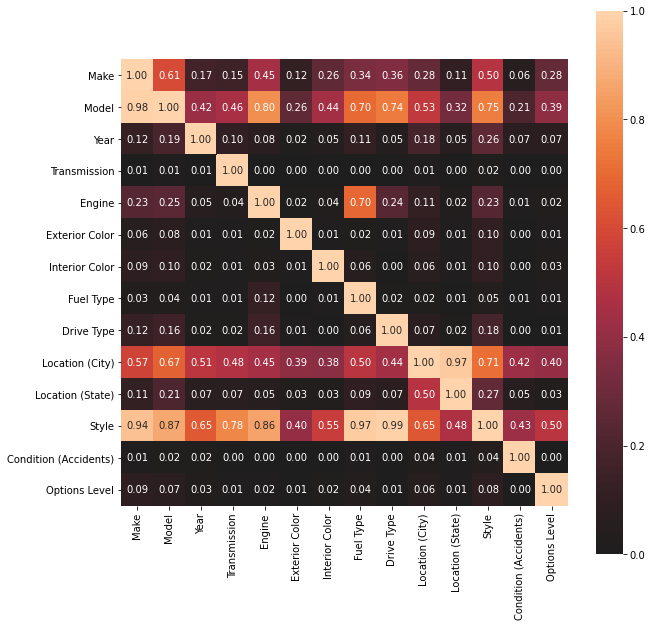

In [101]:
dn.associations(
    categorical_data.dropna(),
    theil_u=True, nan_strategy='drop_samples', figsize=(10,10))['ax']

Then, 'Location (City)' will be eliminated.

In [102]:
vehicles_dataset.drop(columns='Location (City)', inplace=True)

Location (State)' has still a lot of null values to deal with.
Another category representing them will is created.

In [103]:
vehicles_dataset['Location (State)'].value_counts()

TX    1738
CA    1481
FL    1464
VA     714
AZ     682
NC     660
IL     638
GA     517
CO     374
NJ     373
TN     362
WA     361
PA     314
MD     312
OH     300
NY     296
MA     250
SC     249
IN     247
AL     212
OK     206
MO     203
KY     178
CT     172
OR     156
NV     154
UT     131
LA     126
AR     125
WI     109
MN     102
KS      98
MI      94
NE      80
HI      73
NH      72
MS      68
IA      65
NM      60
ME      58
ID      50
MT      43
DE      29
WY      29
AK      23
SD      19
VT      12
ND      11
RI       7
WV       3
SO       1
UK       1
Name: Location (State), dtype: int64

In [104]:
#np.where(vehicles_dataset['Location (State)'] == 'UK', 'Other', vehicles_dataset['Location (State)'])

In [105]:
vehicles_dataset['Location (State)'].apply(lambda st: (st, 'Other')[st in ['UK', 'SO', 'WV', np.NaN]]).value_counts()

TX       1738
CA       1481
FL       1464
VA        714
AZ        682
NC        660
IL        638
GA        517
CO        374
NJ        373
TN        362
WA        361
PA        314
MD        312
OH        300
NY        296
MA        250
SC        249
IN        247
AL        212
OK        206
MO        203
KY        178
CT        172
OR        156
NV        154
UT        131
LA        126
AR        125
WI        109
MN        102
KS         98
MI         94
Other      89
NE         80
HI         73
NH         72
MS         68
IA         65
NM         60
ME         58
ID         50
MT         43
DE         29
WY         29
AK         23
SD         19
VT         12
ND         11
RI          7
Name: Location (State), dtype: int64